# Recommender ChatBot: Evaluation

In [19]:
%%capture output
%load_ext autoreload
%autoreload 2

In [20]:
import os

BASE_PATH    = '../..'
API_PATH     = f'{BASE_PATH}/chat-bot-api'
LIB_PATH     = f'{BASE_PATH}/lib'
DATASET_PATH = f'{BASE_PATH}/datasets'
METRICS_PATH = f'{BASE_PATH}/metrics'
EVAL_METRICS_PATH = f'{METRICS_PATH}/evaluation-metrics.dt'

os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'

In [21]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

import pytorch_common.util as pu

import client
import os

BASE_PATH    = '../..'
API_PATH     = f'{BASE_PATH}/chat-bot-api'
LIB_PATH     = f'{BASE_PATH}/lib'
DATASET_PATH = f'{BASE_PATH}/datasets'

os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'

import util as ut
from faker import Faker

import pandas as pd
import numpy as np

import logging

import metric as mt
from statistics import mean

import numpy as np

# Common Functions and Classes

In [22]:
def genres_count(interactions_test_set, items, user_id):
    df = interactions_test_set[interactions_test_set['user_id'] == user_id]

    item_ids = df['item_id'].unique()
    
    genres = []
    for item_id in item_ids:
        genres.extend(items[items['movie_id'] == item_id]['movie_genres'].tolist()[0])

    return pd.Series(genres).value_counts().reset_index(name='count')



def releases(interactions_test_set, items, user_id):
    df = interactions_test_set[interactions_test_set['user_id'] == user_id]

    return np.sort(items[items['movie_id'].isin(df['item_id'].unique())]['movie_release_year'].unique())

In [23]:
def create_fake_profiles(interactions_test_set, items):
    fake = Faker()

    to_email = lambda name: name.lower().replace(' ', '.') + '@gmail.com'

    user_ids = interactions_test_set['user_id'].unique()

    profiles = []
    emails   = []
    profile_user_ids = []
    for user_id in user_ids:        
        while True:
            name  = fake.name()
            email = to_email(name)
            if email not in emails:
                break

        profile_user_ids.append(user_id)
        emails.append(email)

        genres_count_df = genres_count(interactions_test_set, items, user_id=user_id)
        genres = genres_count_df[genres_count_df['count'] >= 10]['index'].tolist()
    
        release = str(releases(interactions_test_set, items, user_id=user_id)[0])
    
        profiles.append(client.UserProfileDto(
            name             = name,
            email            = email,
            preferred_from   = release,
            preferred_genres = genres
        ))

    logging.debug(f'Profiles: {len(profiles)}')
    logging.debug(f'Users: {len(user_ids)}')
    
    return profiles, profile_user_ids

In [24]:
def reset_env(
    api_client,
    interactions_test_set,
    items
):
    for profile in api_client.profiles():
        api_client.remove_interactions_by_user_id(profile.email)
        api_client.delete_profile(profile.email)

    profiles, user_ids = create_fake_profiles(interactions_test_set, items)

    [api_client.add_profile(profile) for profile in profiles]

    return profiles, user_ids

In [25]:
class RecQueryBuilder:
    def __init__(self, settings):
        self.settings = settings

    def user(self, value):
        self.user_id = value
        return self

    def prompt(self, value):
        self.prompt = value
        return self

    def build(self):
        return {
            'message': {
                'author': self.user_id,
                'content': self.prompt
            },
            'settings': self.settings
        }

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def smooth_lineplot(
    x, 
    y,
    smooth_level              = 0.7,
    confidence_interval_alpha = 0.15,
    label                     = ''
):
    y_smooth = gaussian_filter1d(
        y,
        sigma = smooth_level
    )

    error = np.abs(y_smooth - y)

    sns.lineplot(
        x     = x,
        y     = y_smooth,
        label = label
    )
    plt.fill_between(
        x, 
        y_smooth - error, 
        y_smooth + error, 
        alpha = confidence_interval_alpha
    )

In [27]:
def plot_ndcg_sessions(ndcgs_by_sessions_size):
    plt.figure(figsize=(15,8))

    for size, ndcgs in sorted(ndcgs_by_sessions_size.items()):
        smooth_lineplot(
            x                         = list(range(1, len(ndcgs)+1)),
            y                         = ndcgs,
            label                     = f'{size} Session steps',
            smooth_level              = 0.8
        )
    
    plt.xlabel("Session")
    plt.ylabel("NDGC")
    plt.title("NDGC by session step")
    plt.legend()
    plt.show()

In [ ]:

recomendation_size = 5
max_patience       = 5
plot_interval      = 10


class EvaluationState:    
    
    @staticmethod
    def load():
        return ut.Picket.load(EVAL_METRICS_PATH)

    
    @staticmethod
    def create(
        recomendation_size = 5,
        max_patience       = 5,
        plot_interval      = 10
    ):
        if not os.path.exists(EVAL_METRICS_PATH):
            api_client.verbose_off
            profiles, user_ids  = reset_env(api_client, interactions_test_set, items)
            api_client.verbose_on
            return EvaluationState(
                recomendation_size,
                max_patience,
                plot_interval,            
                profiles, 
                user_ids, 
                profiles_by_user_id
            )
        else:
            return EvaluationState.load()


    def __init__(
        self,
        recomendation_size,
        max_patience,
        plot_interval,
        profiles,
        user_ids,
        profiles_by_user_id
    ):
        self.recomendation_size  = recomendation_size
        self.max_patience        = max_patience
        self.plot_interval       = plot_interval
        self.metrics_by_user_id  = { u: p for p, u in zip(profiles, user_ids) }
        self.profiles            =  profiles
        self.profiles_by_user_id = profiles_by_user_id

    
    def save(self):
        ut.Picket.save(EVAL_METRICS_PATH, self)


    def find_profile_by_user_id(self, user_id):
        return self.profiles_by_user_id[user_id]

    
    def plot_metrics(self):
        ndcg_groups = {}

        for user_id, sessions in self.metrics_by_user_id.items():
            values = [session['votes_ndgc'] for session in sessions]
        
            if len(values) < 3:
                continue

            if len(values) in ndcg_groups:
                ndcg_groups[len(values)] = np.vstack((ndcg_groups[len(values)], values))
            else:
                ndcg_groups[len(values)] = np.array(values)
        
        
        ndcgs_by_sessions_size = {size: np.mean(matrix, axis=0) for size, matrix in ndcg_groups.items() if len(matrix.shape) > 1 }
        plot_ndcg_sessions(ndcgs_by_sessions_size)

## Setup

In [11]:
def on_file(file_path, format='%(asctime)s - %(levelname)s - %(message)s'):
    handler = logging.FileHandler(file_path)
    handler.setFormatter(logging.Formatter(format))
    return handler

pu.LoggerBuilder() \
    .handler(on_file('./evaluation.log'))\
    .on_console() \
    .build()

<RootLogger root (INFO)>

**Step 1**: Load interactions test set.

In [12]:
interactions_test_set = ut.load_df(f'{DATASET_PATH}/interactions_test_set.json')

In [13]:
items = ut.load_df(f'{DATASET_PATH}/pre-processed-movies.json')

**Step 2**: Create **Recommendation Chatbot API** client.

In [14]:
api_client = client.RecChatBotV1ApiClient()

In [15]:
api_client.health

2024-03-30 09:31:42,073 - INFO - GET http://nonosoft.ddns.net:8080/api/v1/health



{
    'chatbot_api': True,
    'ollama_api': True,
    'airflow': {'metadatabase': True, 'scheduler': True},
    'mongo_database': True,
    'choma_database': True
}

**Step 3**: Create profiles for test users.

In [16]:
hyper_params = {
    'llm'                                   : 'llama2-7b-chat',
    'retry'                                 : 2,
    'plain'                                 : False,
    'include_metadata'                      : True,
    'rag': {
        'shuffle'                           : False,
        'candidates_limit'                  : 100,
        'llm_response_limit'                : 100,
        'recommendations_limit'             : 10,
        'similar_items_augmentation_limit'  : 10,
        'not_seen'                          : True
    },
    'collaborative_filtering': {
        'shuffle'                           : False,
        'candidates_limit'                  : 50,
        'llm_response_limit'                : 50,
        'recommendations_limit'             : 10,
        'similar_items_augmentation_limit'  : 5,
        'text_query_limit'                  : 5000,
        'k_sim_users'                       : 10,
        'random_selection_items_by_user'    : 0.5,
        'max_items_by_user'                 : 10,
        'min_rating_by_user'                : 3.5,
        'not_seen'                          : True
    }
}

In [ ]:
recomendation_size = 5
max_patience       = 5
plot_interval      = 10
evaluation_state   = EvaluationState.create()
 
interactions_test_set      = interactions_test_set.sort_values(by=['timestamp'])
interactions_by_user_id_df = interactions_test_set.groupby(['user_id'])

In [ ]:
def sample(df, size): return df.sample(frac = 1).head(size)

def is_in(df1, left_col, df2, right_col): return df1[df1[left_col].isin(df2[right_col])]

def is_remaining(df, api_client, profile):
    user_voted_item_ids       = [int(i.item_id) for i in api_client.interactions_by_user(profile.email)]
    return df[~df['item_id'].isin(user_voted_item_ids)]

def n_items(df): return len(rdf["item_id"].unique())

def make_request(
    api_client,
    hyper_params,
    log_prefix,
    profile,
    remaining_items_sample
):
        prompt = f'I want to see {ut.str_join(remaining_items_sample['movie_title'].values.tolist())}'

        logging.info(f'{log_prefix}Found {len(remaining_items_sample)} items({remaining_interactions_df.pipe(n_items)} remaining). ')
        logging.info(f'{log_prefix}Promp: {prompt}')

        return api_client.recommendations(
            RecQueryBuilder(hyper_params) \
                .user(profile.email) \
                .prompt(prompt) \
                .build() 
        )

In [ ]:
from IPython.display import clear_output

times = 1
api_client.verbose_off
for user_id in interactions_by_user_id_df.groups.keys():
    if  user_id in evaluation_state['metrics_by_user_id']:
        continue

    profile          = evaluation_state.find_profile_by_user_id(user_id)
    interactions_df  = interactions_by_user_id_df.get_group((user_id,))

    patience         = 0
    log_prefix       = f'{profile.email} - '
    logging.info(f'{log_prefix}Begin to register eval metrics.')

    while True:
        remaining_interactions_df = interactions_df.pipe(is_remaining, api_client, profile)

        remaining_interactions_sample_df   = remaining_interactions_df.pipe(sample, recomendation_size)    
        if len(remaining_interactions_sample_df) <= 1:
            break

        remaining_items_sample = items.pipe(is_in, 'movie_id', remaining_interactions_sample_df, 'item_id')

        try:
            result = make_request(
                api_client,
                hyper_params,
                log_prefix,
                profile,
                remaining_items_sample
            )
        except client.NotFoundException as err:
            logging.info(f'{log_prefix}End process. Retrain CF models to continue evaluation.')
            break
        
        except Exception as err:
            logging.error(err)
            continue
    
        rating_by_item_id = remaining_items_sample.pipe(ut.to_dict, 'movie_id', 'user_movie_rating')
        
        result_eval_items = list(filter(lambda x: int(x.id) in rating_by_item_id.keys(), result.items))
    
        logging.info(f'{log_prefix}Found {len(result_eval_items)} results...')
 
        if len(result_eval_items) <= 1: 
            if patience >= max_patience:
                logging.warning(f'{log_prefix}End process. {max_patience} max retries reached.')
                break

            patience += 1
            logging.warning(f'{log_prefix}Found {len(result_eval_items)} results. Patience: {patience}/{max_patience}.')
            continue
        else:
            patience = 0
            
    
        mean_user_rating = mean(rating_by_item_id.values())
            
        metric_item_ids = []
        metric_votes    = []
        for result_eval_item in result_eval_items:        
            item_id = int(result_eval_item.id)
            metric_item_ids.append(item_id)
    
            rating = rating_by_item_id[item_id]
            metric_votes.append(rating)
                
            result_eval_item.vote(rating)
    
    
        if user_id not in evaluation_state['metrics_by_user_id']:
            evaluation_state['metrics_by_user_id'][user_id] = []

        sessions = evaluation_state['metrics_by_user_id'].get(user_id)

        sessions.append({
            'items': metric_item_ids,
            'votes': metric_votes,
            'votes_ndgc': mt.ndcg(metric_votes)
        })

        logging.info(f'{log_prefix}Session eval metrics registered successfully...')

    evaluation_state.save()
    clear_output(wait=True)

    if times % plot_interval == 0:
        evaluation_state.plot_metrics()

    times += 1

api_client.verbose_on

In [30]:
evaluation_state = ut.Picket.load(EVAL_METRICS_PATH)

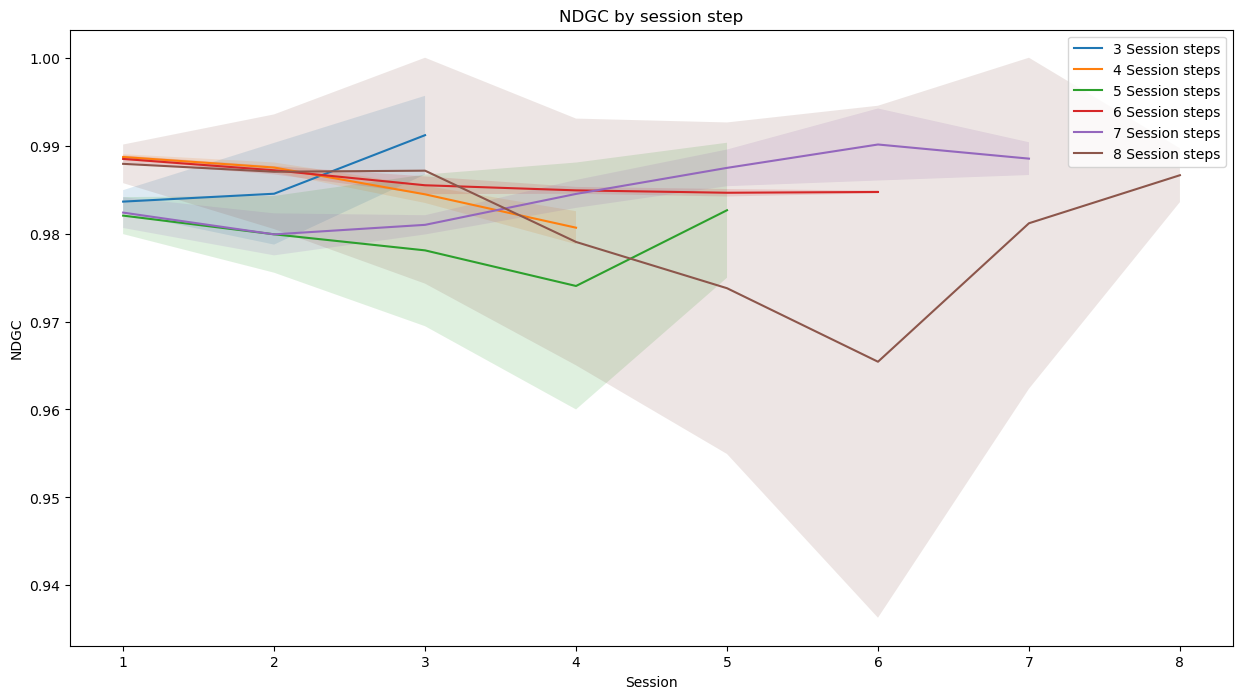

In [29]:
plot_metrics(evaluation_state)

https://colab.research.google.com/drive/1ySN-gbMt6-5OeXCnp8-NorrmfJ24jw2y

In [33]:
# evaluation_state

In [38]:
evaluation_state['metrics_by_user_id'][3503]


[
    {'items': [115569, 26471, 31672], 'votes': [3.95, 3.5, 3.0], 'votes_ndgc': 1.0},
    {'items': [1269, 55269, 7924], 'votes': [4.0689655172, 3.7195121951, 3.7], 'votes_ndgc': 1.0},
    {'items': [2932, 71108], 'votes': [3.5238095238, 3.36], 'votes_ndgc': 1.0},
    {
        'items': [4102, 46441, 72276],
        'votes': [3.8333333333, 1.0, 2.0],
        'votes_ndgc': 0.9765995994588288
    },
    {'items': [6539, 43376], 'votes': [3.8622047244, 3.7727272727], 'votes_ndgc': 1.0},
    {
        'items': [27803, 128606, 8694, 64280],
        'votes': [3.71875, 3.5, 3.0, 4.0],
        'votes_ndgc': 0.9745865243693221
    }
]

In [34]:
def mean_reciprocal_rank(recommended_items_list, relevant_items_list):
    if len(recommended_items_list) != len(relevant_items_list):
        raise ValueError("The length of recommended_items_list and relevant_items_list must be the same.")

    reciprocal_ranks = []

    # Iterate through the lists of recommended items and relevant items for each user
    for recommended_items, relevant_items in zip(recommended_items_list, relevant_items_list):
        # Find the reciprocal rank for each user
        for rank, item in enumerate(recommended_items, start=1):
            if item in relevant_items:
                reciprocal_ranks.append(1 / rank)
                break
        else:
            reciprocal_ranks.append(0)

    # Calculate the mean reciprocal rank
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
    return mrr

# Example usage
recommended_items_list = [
    [1, 3, 5, 7, 9],
    [2, 4, 6, 8],
    [11, 12, 13, 14, 15, 16, 17]
]

relevant_items_list = [
    [2, 3, 5, 7, 11],
    [1, 4, 6, 8, 9],
    [16, 17, 18, 19, 20]
]

mrr = mean_reciprocal_rank(recommended_items_list, relevant_items_list)
print(f"Mean Reciprocal Rank: {mrr:.2f}")

Mean Reciprocal Rank: 0.39